# 1. Startup Application and Internal Memory 

In [5]:
!ls
!pip install -r requirements.txt --quiet

README.md             functions             requirements.txt
__pycache__           hopsworks-api-key.txt tests.ipynb
cache                 keys.py               variables
figures               notebooks


In [1]:
import pickle
import pandas as pd
import hopsworks
import os

from keys import TOMTOM_API_KEY, TOMTOM_API_KEY2, TOMTOM_API_KEY3
from functions.TomTomAPI import get_traffic_map, plot_traffic_map, get_grid_from_map, get_traffic_map_from_grid, get_grid_from_map_alt
from functions.HolidaysnWeather import get_weather, is_holiday

/Users/diogosilva/Documents/Scalable ML and DeepL/Project-ID2223_TrafficApp/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
coordinates = 59.34318, 18.05141 # Stockholm near Odenplan
radius = 1000
zoom = 20

TOMTOM_keys = [TOMTOM_API_KEY, TOMTOM_API_KEY2, TOMTOM_API_KEY3]

### 1.1. Create GRID for extracting traffic data

In [8]:
success = False
i = 0
while i < len(TOMTOM_keys) and not success:
    try:
        traffic_map = get_traffic_map(TOMTOM_keys[i], coordinates, radius, zoom = zoom)
        success = True
    except:
        print('Failed with key:', i)
        i += 1

eliminated: 7
eliminated: 3
{'error': 'Point too far from nearest existing segment.', 'httpStatusCode': 400, 'detailedError': {'code': 'INVALID_REQUEST', 'message': 'Point too far from nearest existing segment.'}}
eliminated: 2
eliminated: 2
eliminated: 1
{'error': 'Point too far from nearest existing segment.', 'httpStatusCode': 400, 'detailedError': {'code': 'INVALID_REQUEST', 'message': 'Point too far from nearest existing segment.'}}
{'error': 'Point too far from nearest existing segment.', 'httpStatusCode': 400, 'detailedError': {'code': 'INVALID_REQUEST', 'message': 'Point too far from nearest existing segment.'}}
{'error': 'Point too far from nearest existing segment.', 'httpStatusCode': 400, 'detailedError': {'code': 'INVALID_REQUEST', 'message': 'Point too far from nearest existing segment.'}}
{'error': 'Point too far from nearest existing segment.', 'httpStatusCode': 400, 'detailedError': {'code': 'INVALID_REQUEST', 'message': 'Point too far from nearest existing segment.'}}


1145
303


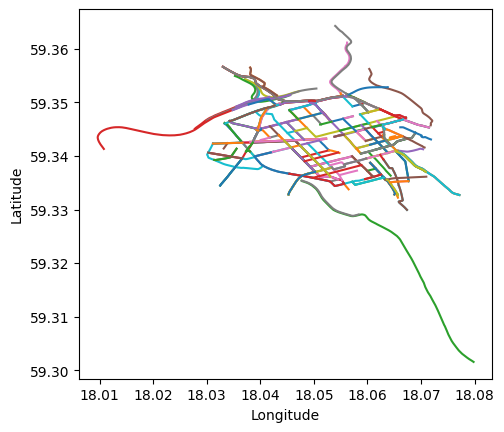

In [9]:
print(len(traffic_map))
traffic_map = set([str(s) for s in traffic_map])
traffic_map = [eval(s) for s in list(traffic_map)]
print(len(traffic_map))

plot_traffic_map(traffic_map)

In [10]:
grid = get_grid_from_map(traffic_map)

with open('variables/grid.pickle', 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(grid, file)

### 1.2. Collect traffic data

Failed with key: 0
num of requests: 303
303
186


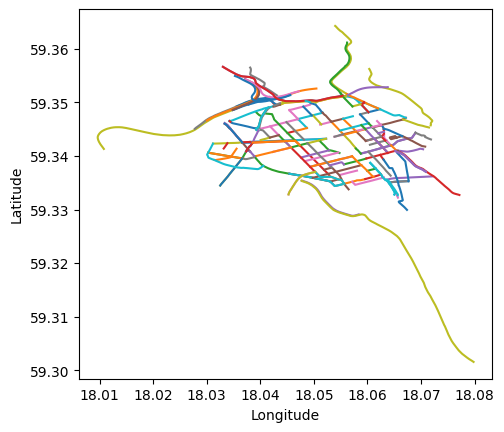

In [3]:
# Getting grid variable from memory
with open('variables/grid.pickle', 'rb') as file:
    # Deserialize and retrieve grid from pickle file
    grid = pickle.load(file)

success = False
i = 0
while i < len(TOMTOM_keys) and not success:
    try:
        traffic_map2 = get_traffic_map_from_grid(TOMTOM_keys[i],grid, zoom = zoom)
        success = True
    except:
        print('Failed with key:', i)
        i += 1

print(len(traffic_map2))
traffic_map2 = set([str(s) for s in traffic_map2])
traffic_map2 = [eval(s) for s in list(traffic_map2)]
print(len(traffic_map2))

plot_traffic_map(traffic_map2, name = 'figures/traffic_map2.png')

In [11]:
from shapely.geometry import LineString
import datetime

traffic_df = pd.DataFrame(traffic_map2)
traffic_df['coordinates'] = traffic_df['coordinates'].apply(lambda x: LineString([(point['longitude'], point['latitude']) for point in x['coordinate']]))
traffic_df = traffic_df.drop_duplicates()
traffic_df['coordinates'] = traffic_df['coordinates'].apply(lambda x: str(x))

traffic_df['relativeSpeed'] = traffic_df.apply(lambda x: x['currentSpeed'] - x['freeFlowSpeed'], axis = 1)

today = datetime.datetime.now()
today = today.replace(second=0, microsecond=0, minute=0, hour=today.hour) + datetime.timedelta(hours=today.minute//30)
traffic_df['date']= [today for i in range(traffic_df.shape[0])]

traffic_df = traffic_df.drop(columns = ['@version'])

print(traffic_df.shape)
traffic_df.head()

(186, 10)


,frc,currentSpeed,freeFlowSpeed,currentTravelTime,freeFlowTravelTime,confidence,roadClosure,coordinates,relativeSpeed,date
0,FRC6,9,19,131,62,0.98,False,LINESTRING (18.03925033613089 59.3451686539145...,-10,2024-12-18 15:00:00
1,FRC5,10,18,89,49,1.00,False,LINESTRING (18.05958818599109 59.3356870333409...,-8,2024-12-18 15:00:00
2,FRC7,21,21,21,21,1.00,False,LINESTRING (18.054783008539772 59.340549861733...,0,2024-12-18 15:00:00
3,FRC4,22,30,70,51,1.00,False,LINESTRING (18.033338747460704 59.346013541683...,-8,2024-12-18 15:00:00
4,FRC4,7,17,261,107,1.00,False,LINESTRING (18.072202614991028 59.336191288713...,-10,2024-12-18 15:00:00


### 1.3. Collect weather data

In [12]:
weather_df = get_weather(coordinates)
weather_df

,date,temperature_2m_max,temperature_2m_min,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,2024-12-18 15:00:00,5.776,-0.674,4.5,24.48,186.990036


### 1.4. Collect weather data

In [13]:
holiday_status = is_holiday()
weather_df['holiday_status'] = holiday_status
weather_df

,date,temperature_2m_max,temperature_2m_min,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,holiday_status
0,2024-12-18 15:00:00,5.776,-0.674,4.5,24.48,186.990036,0


### 1.5. Joining data and uploading to Hopsworks

In [14]:
# Get the API key from GitHub Secrets
# HOPSWORKS_API_KEY = os.getenv('HOPSWORKS_API_KEY')
with open('hopsworks-api-key.txt','r') as file:
    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

# Get AQI API KEY from secrets of hopsworks
project = hopsworks.login(project="ID2223LAB1KTH", api_key_value=os.environ["HOPSWORKS_API_KEY"])

2024-12-18 15:00:19,329 INFO: Closing external client and cleaning up certificates.
Connection closed.
2024-12-18 15:00:19,341 INFO: Initializing external client
2024-12-18 15:00:19,343 INFO: Base URL: https://c.app.hopsworks.ai:443
2024-12-18 15:00:20,426 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1170583


In [17]:

# Initialize the feature store

fs = project.get_feature_store()

# Define and insert the Air Quality Feature Group
traffic_fg = fs.get_or_create_feature_group(
    name="stockholm_traffic",
    version=1,
    description="Traffic data of odenplan : coordinates currentSpeed	freeFlowSpeed	currentTravelTime	freeFlowTravelTime	confidence	roadClosure",
    primary_key=["date"],  
    event_time="date" 
)

traffic_fg.insert(traffic_df)

# Define and insert the Air Quality Feature Group
weather_fg = fs.get_or_create_feature_group(
    name="stockholm_weather_holiday",
    version=1,
    description="Weather data for Stockholm including temperature, precipitation, wind speed and holiday",
    primary_key=["date"],  
    event_time="date" 
)

weather_fg.insert(weather_df)

Uploading Dataframe: 100.00% |██████████| Rows 186/186 | Elapsed Time: 00:01 | Remaining Time: 00:00


Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1170583/fs/1161286/fg/1391996


Uploading Dataframe: 100.00% |██████████| Rows 1/1 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: stockholm_weather_holiday_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1170583/jobs/named/stockholm_weather_holiday_1_offline_fg_materialization/executions


(Job('stockholm_weather_holiday_1_offline_fg_materialization', 'SPARK'), None)